In [1]:
import numpy as np #vectors and matrices
import pandas as pd #tables and data manipulations
import matplotlib.pyplot as plt #plots
import seaborn as sns #more plots
from dateutil.relativedelta import relativedelta # working with dates with stylefrom scipy.optimize import minimize
import statsmodels.api as sm
# for function minimization
#from fbprophet import Prophet

from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

In [2]:
#read data from csv
df = pd.read_csv('stock_data.csv')
df.set_index('Date', inplace=True)
print(df.columns)



#for mapping the ticker in df
cond = {'1' : 'AMZN', '2': 'TIF','3':'HD','4':"AAPL",'5':"WMT"}

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'ticker'], dtype='object')


In [3]:
#spliting ticker data seprately
amzn_data = df.loc[df.ticker == cond['1'], ['Close']]  #for AMZN

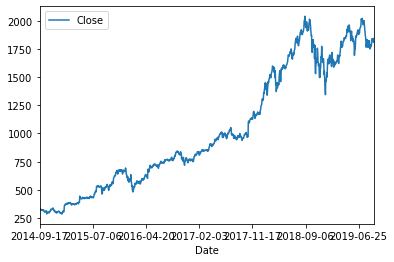

In [4]:
amzn_data.plot()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000643C710208>]],
      dtype=object)

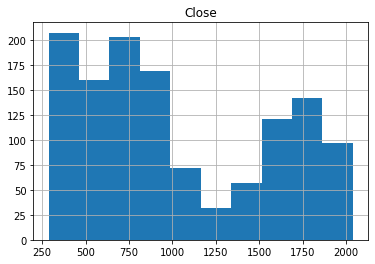

In [5]:
amzn_data.hist()


In [5]:
am_df = amzn_data.copy()
split = len(am_df) / 2

split= int(split)
print(split)
X1, X2 = am_df[0:split], am_df[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

630
mean1=576.276334, mean2=1484.857921
variance1=31711.703999, variance2=132500.675076


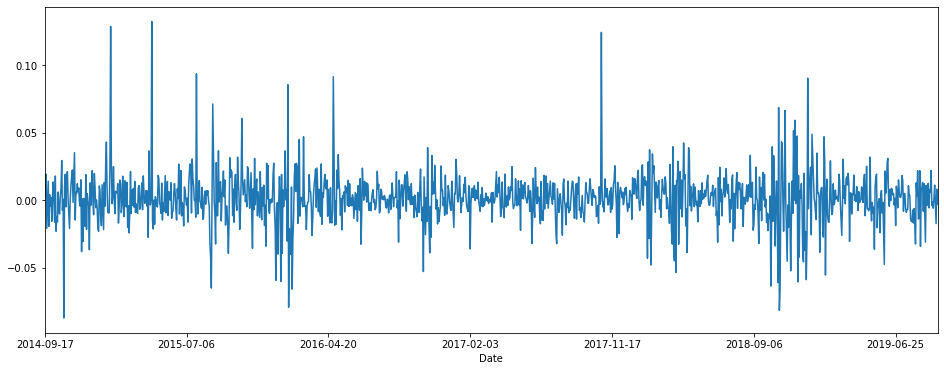

In [6]:
#calulating the first difference
amzn_data['first_diff'] = amzn_data['Close'] - amzn_data['Close'].shift()

amzn_data['pct_chnge_fd'] = ((amzn_data['first_diff'] - amzn_data['first_diff'].shift())/amzn_data['first_diff'])*100


amzn_data['pct_chnge_fd_log'] = amzn_data['pct_chnge_fd'].apply(lambda x: np.log(x))



amzn_data['natural_log'] = amzn_data['Close'].apply(lambda x: np.log(x))

amzn_data['fdiff_nl'] = amzn_data['natural_log'] - amzn_data['natural_log'].shift()

amzn_data['fdiff_nl'].plot(figsize=(16,6))

In [7]:
am_df = amzn_data.copy()
split = len(am_df) / 2

split= int(split)
print(split)
X1, X2 = am_df[0:split], am_df[split:]
mean1, mean2 = X1['fdiff_nl'].mean(), X2['fdiff_nl'].mean()
var1, var2 = X1['fdiff_nl'].var(), X2['fdiff_nl'].var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

630
mean1=0.001538, mean2=0.001202
variance1=0.000356, variance2=0.000336


In [8]:
from numpy import log


result = adfuller(amzn_data['fdiff_nl'])    # faltten() opens the array into list of values that adfuller() requires

print('STOCK DATA:\nADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

MissingDataError: exog contains inf or nans

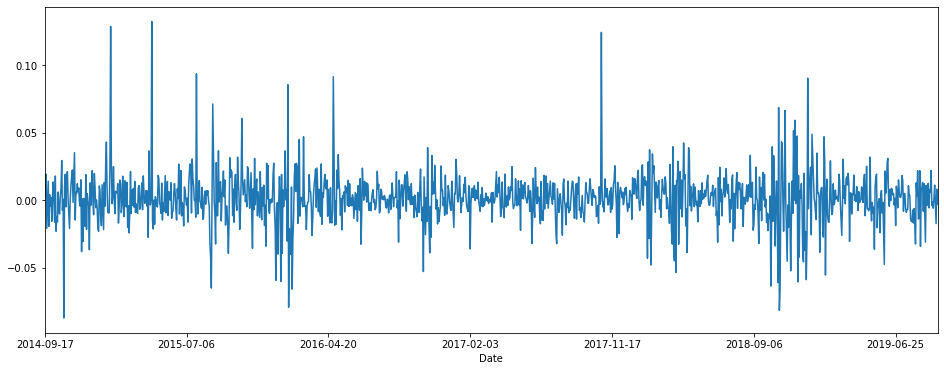

In [9]:
amzn_data['fdiff_nl'].plot(figsize=(16,6))


In [10]:
amzn_data['Lag 1']  = amzn_data['fdiff_nl'].shift(1)
amzn_data['Lag 2']  = amzn_data['fdiff_nl'].shift(2)
amzn_data['Lag W']  = amzn_data['fdiff_nl'].shift(5)
amzn_data['Lag M']  = amzn_data['fdiff_nl'].shift(30)


C:\Users\ankjain\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



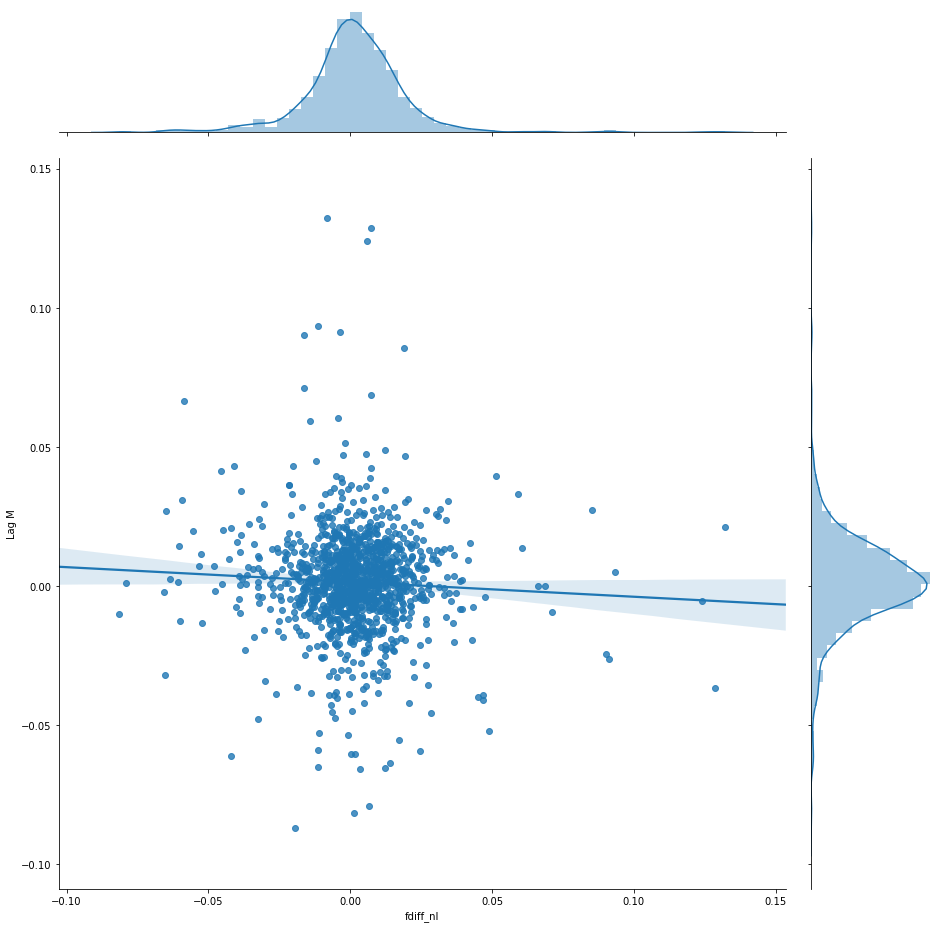

In [13]:
sns.jointplot('fdiff_nl', 'Lag M', amzn_data, kind='reg', size=13)

Index(['Close', 'first_diff', 'pct_chnge_fd', 'pct_chnge_fd_log',
       'natural_log', 'fdiff_nl', 'Lag 1', 'Lag 2', 'Lag W', 'Lag M'],
      dtype='object')
[ 1.          0.01420102 -0.03065501 -0.03371824 -0.02373289  0.02609527
 -0.00183823 -0.01167267 -0.04894304  0.04734477 -0.01738852 -0.02200503
 -0.02654234  0.00213527 -0.02869953 -0.00672907  0.03903379  0.04389112
  0.02541037  0.00401616 -0.0121706  -0.05027471  0.00513536  0.04809041
 -0.02062538 -0.01916414  0.0118587   0.00254856  0.0184423  -0.06839449
 -0.05152837]


C:\Users\ankjain\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



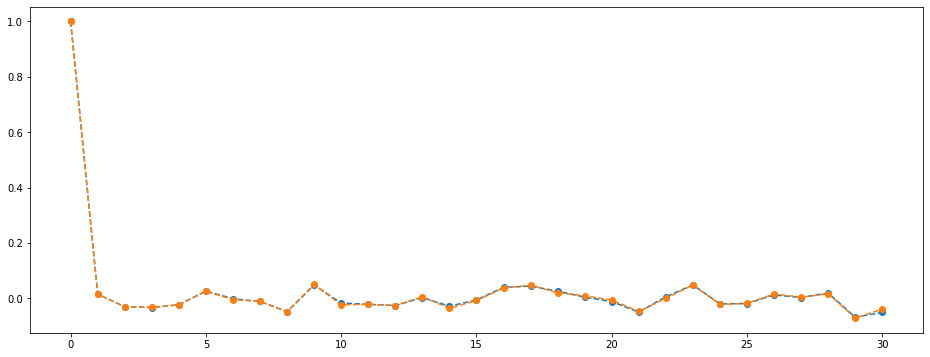

In [11]:
print(amzn_data.columns)
lag_correlations = acf(amzn_data['fdiff_nl'].iloc[1:] , nlags=30)
lag_partial_correlations = pacf(amzn_data['fdiff_nl'].iloc[1:],nlags=30)

print(lag_correlations)

fig, ax = plt.subplots(figsize=(16,6))  
ax.plot(lag_correlations, marker='o', linestyle='--')

ax.plot(lag_partial_correlations, marker='o', linestyle='--')

<Figure size 432x288 with 0 Axes>

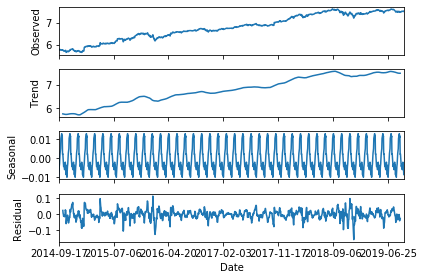

In [12]:
#print(amzn_data.describe())

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(amzn_data['natural_log'], model='additive', freq=30)
#print(decomposition)
fig = plt.figure()  
fig = decomposition.plot()

In [27]:
#print(amzn_data[amzn_data.index.duplicated()]

amzn_data = amzn_data.loc[~amzn_data.index.duplicated(keep='first')]

amzn_data = amzn_data.dropna()

model = sm.tsa.ARIMA(amzn_data['fdiff_nl'].iloc[1:], order=(1, 1, 1))  
results = model.fit(disp=-1)

amzn_data['Forecast'] = results.fittedvalues  
#amzn_data[[ 'fdiff_nl','Forecast']].plot(figsize=(16, 8))

yhat_f = results.forecast()[0][0]
print(yhat_f)

yhat_p = results.predict(start=900, end=900)[0]
print(yhat_p)
#predictions_f.append(yhat_f)
#predictions_p.append(yhat_p)
#ARIMA.predict(results, start=None, end=None, exog=None, typ='linear', dynamic=False)
#print(amzn_data)

C:\Users\ankjain\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ankjain\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



0.0008624031392044079
-0.012129287832919023


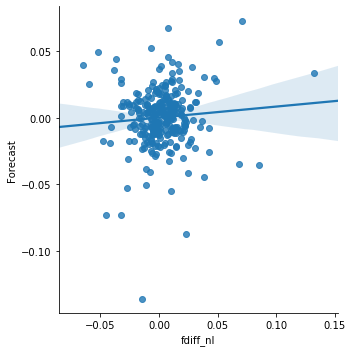

In [213]:
sns.lmplot(x='fdiff_nl',y='Forecast',data = amzn_data)

True